<a class="anchor" id="top_of_document"></a>


# Project Description

__Project Overview__
- Interconnect provides landline communication, internet, and several complimentary services. 
- Clients select a monthly payment or yearly contracts.
- Interconnect wants a model for *predicting the churn of clientele*.
- If a user is forecast to leave, they will be offered promotional codes and special plan options.

__Data Description__
- Data is valid as of February 1, 2020.
- Four data files from different souces are provided.
 1. `contract.csv` - contract information
 2. `personal.csv` - the client's personal data
 3. `internet.csv` - information about Interenet services
 4. `phone.csv` - information about telephone services
- The files are linked by the `customerID` column which contains a unique code assigned to each client. 
- The target feature is the `EndDate` column equal to `No`.

__Project Goal__
- Create a classification model that predicts if a customer will leave soon based on the data files supplied.
- AUC-ROC is the primary metric and needs to be at least 0.81, though greater than or equal to 0.88 is ideal.
- Accuracy will also be reported.

Steps:
1. [Load and inspect the data](#load_inspect)
2. [Data preprocessing](#data_preprocessing)
3. [Exploratory data analysis](#exploratory_data_analysis)
4. [Modeling plan](#modeling_plan)
5. [Function for scores](#function_for_scores) 
6. [Split data](#split_data)
7. [Explore balance](#explore_balance)
8. [Build models](#model_building)
9. [Conclusions](#conclusions)

Report prepared March 2022

<a class="anchor" id="load_inspect"></a>

# Data Preprocessing & Exploration

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style='ticks', palette='Set2')
%matplotlib inline
import math
import time
from functools import reduce
import re # changing column names
# from sklearn.preprocessing import OneHotEncoderer
from IPython.display import HTML, display # for table

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier 
from xgboost import XGBClassifier
from sklearn.utils import shuffle 

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

import random
random_state=42
random.seed(random_state)
np.random.seed(random_state)

# import sys and insert code to ignore warnings 
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Import files

In [2]:
# load the data 
try:
    contract = pd.read_csv('/Users/rraven/Desktop/Yandex/final_project/interconnect_data/contract.csv')
    personal = pd.read_csv('/Users/rraven/Desktop/Yandex/final_project/interconnect_data/personal.csv')
    internet = pd.read_csv('/Users/rraven/Desktop/Yandex/final_project/interconnect_data/internet.csv')
    phone = pd.read_csv('/Users/rraven/Desktop/Yandex/final_project/interconnect_data/phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv') 
    personal = pd.read_csv('/datasets/final_provider/personal.csv') 
    internet = pd.read_csv('/datasets/final_provider/internet.csv') 
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
contract.info()
print('Number of missing values', contract.isnull().sum())
print('Number of duplicate rows', contract.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
Number of missing values customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64
Number of duplicate rows 0


__Observations__
- The contract file has 7043 entries, no missing values, no duplicate rows.
- Several datatypes will need to be addressed.
- BeginDate needs to be changed to_datetime.
- EndDate contains the target, but also useful information regarding length of contract for those who have left. We may need to duplicate this column and create a binary 0/1 for EndDate and a to_datetime for the dates of those who left. It is possible that we could replace 2020-02-01 date for those where EndDate = 'No' to indicate they are still customers. It may also be useful to create a length of service column as well.
- Type could be better as a numeric code, consider OHE.
- Payment method could also be better as a numeric code, consider OHE.
- Total charges need to be changed to float 64.

In [5]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
personal.info()
print('Number of missing values', personal.isnull().sum())
print('Number of duplicate rows', personal.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
Number of missing values customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
Number of duplicate rows 0


__Observations__
- The personal file has 7043 entries, no missing values, no duplicate rows.
- Consider OHE for these features ('gender', 'SeniorCitizen', 'Partner', 'Dependents').

In [7]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
# create yes/no column to indicate internet customer
internet['InternetCustomer'] = 'Yes'

In [9]:
internet.info()
print('Number of missing values', internet.isnull().sum())
print('Number of duplicate rows', internet.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
 8   InternetCustomer  5517 non-null   object
dtypes: object(9)
memory usage: 388.0+ KB
Number of missing values customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
InternetCustomer    0
dtype: int64
Number of duplicate rows 0


__Observations__
- The internet file has 5517 internet customers. 
- We created a column to indicate 'internet_customer' so the information is retained when we merge files. After merging, we will fill in the missing values with no and consider OHE.
- Consider OHE for these features ('InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies').

In [10]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [11]:
# create yes/no column to indicate internet customer
phone['PhoneCustomer'] = 'Yes'

In [12]:
phone.info()
print('Number of missing values', phone.isnull().sum())
print('Number of duplicate rows', phone.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
 2   PhoneCustomer  6361 non-null   object
dtypes: object(3)
memory usage: 149.2+ KB
Number of missing values customerID       0
MultipleLines    0
PhoneCustomer    0
dtype: int64
Number of duplicate rows 0


In [13]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

__Observations__
- The personal file has 6361 phone customers
- We created a column to indicate 'phone_customer' so the information is retained when we merge files. After merging, we will fillin the missing values with no and consider OHE.
- Consider OHE for these features ('MultipleLines').

<a class="anchor" id="data_preprocessing"></a>

## Preprocessing Tasks

- Merge four files on shared customerID and then drop customerID column.
- Change column names to all lower case for uniformity.
- BeginDate needs to be changed to_datetime.
- EndDate contains the target, but also useful information regarding length of contract for those who have left. We may need to duplicate this column and create a binary 0/1 for EndDate and a to_datetime for the dates of those who left. It is possible that we could replace 2020-02-01 date for those where EndDate = 'No' to indicate they are still customers. It may also be useful to create a length of service column as well.
- Drop BeginDate and EndDate.
- Total charges need to be changed to float 64.
- Missing values need to be found and replaced.

In [14]:
# merge 4 files into 1 df
data_frames = [contract, personal, internet, phone]
df = reduce(lambda left, right:pd.merge(left, right, how='outer'), data_frames)
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,InternetCustomer,MultipleLines,PhoneCustomer
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,Yes,NaN,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,...,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,Yes,NaN,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,Yes,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,...,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,...,DSL,Yes,No,No,No,No,No,Yes,NaN,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Male,1,...,Fiber optic,No,No,No,No,No,No,Yes,Yes,Yes


In [15]:
# remove customerID as it will not be useful in analysis
df = df.drop(['customerID'], axis=1)

In [16]:
# change column names to all lower case
columns = []
for name in df.columns.values:
    # note if we use [1:] sometimes we may drop the first letter
    # but [0:] may lead to a _before every name
    name = re.sub('([A-Z])', r' \1', name).lower().replace(' ', '_')[1:]
    columns.append(name)
df.columns = columns
df.head(1)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,ender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,internet_customer,multiple_lines,phone_customer
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,Yes,NaN,NaN


In [17]:
# change the column names with missing letters back
df = df.rename(columns = {'ender':'gender'})
df.head(1)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,internet_customer,multiple_lines,phone_customer
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,Yes,NaN,NaN


In [18]:
# change begin_date to_datetime
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   object        
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   object        
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14  device_p

In [19]:
# create a column for the target from end_date

def target_fx(row):
    # the income_level is returned according to total_income
    value = row['end_date']   
    if value == 'No':
        return 0
    else:
        return 1
    
# create a new column
df['target'] = df.apply(target_fx, axis=1)

# verfiy new column: income_level
df['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

In [20]:
# change 'no' values in end_date to feb 1st 2020
df.loc[df['end_date'] == 'No', 'end_date'] = '2020-02-01 00:00:00'

In [21]:
# investigate if the format needs hours and minutes
df['end_date'].value_counts()

2020-02-01 00:00:00    5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

In [22]:
# change end_date to_datetime
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   object        
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14  device_p

In [23]:
# create a new column with the length of service
final_date = pd.to_datetime('2020-02-01') 
df['length_of_service'] = (final_date - df['begin_date']).dt.days
df['length_of_service'].value_counts().sort_index()

0        11
31      233
62      220
92      237
123     237
       ... 
2191    366
2222      7
2253      3
2283      2
2314      3
Name: length_of_service, Length: 77, dtype: int64

In [24]:
# verify that the users with 0 length of service started 2020-02-01
df.query('length_of_service == 0')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,internet_customer,multiple_lines,phone_customer,target,length_of_service
488,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,...,No,Yes,Yes,Yes,No,Yes,NaN,NaN,0,0
753,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,No,...,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,0,0
936,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,Yes,...,Yes,Yes,No,Yes,Yes,Yes,No,Yes,0,0
1082,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,0,0
1340,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,...,Yes,Yes,Yes,Yes,No,Yes,NaN,NaN,0,0
3331,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,0,0
3826,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,0,0
4380,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,0,0
5218,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,0,0
6670,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,Female,0,Yes,...,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,0,0


In [25]:
# verify there are missing values in total_charges
df.total_charges.value_counts().sort_index()

          11
100.2      1
100.25     1
100.35     1
100.4      1
          ..
997.75     1
998.1      1
999.45     1
999.8      1
999.9      1
Name: total_charges, Length: 6531, dtype: int64

__Observation__
- We note there is no amount listed in the total charges for new users.
- Since we have the monthly amount chaged and they are new as of 2020-02-01, we can assume the total charges should match the monthly charge for those customers.

In [26]:
# fill in missing total_charges with montly_charge for new customers
df.loc[df['total_charges'] == ' ', 'total_charges'] = df['monthly_charges']
df.query('length_of_service == 0')

# change the datatype of total_charges to float
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
df['total_charges'] = df['total_charges'].astype('float')
df['total_charges'].dtype

dtype('float64')

In [27]:
# verify there are no missing values in total_charges
df.total_charges.value_counts().sort_index()

18.80      1
18.85      2
18.90      1
19.00      1
19.05      1
          ..
8564.75    1
8594.40    1
8670.10    1
8672.45    1
8684.80    1
Name: total_charges, Length: 6534, dtype: int64

In [28]:
# check for distribution of values in columns missing values
cols = [df.online_security, df.online_backup, df.device_protection,
        df.tech_support, df.streaming_t_v, df.streaming_movies,
        df.multiple_lines, df.internet_customer, df.phone_customer,
           df.internet_service]

for x in cols:
    print(x.value_counts())

No     3498
Yes    2019
Name: online_security, dtype: int64
No     3088
Yes    2429
Name: online_backup, dtype: int64
No     3095
Yes    2422
Name: device_protection, dtype: int64
No     3473
Yes    2044
Name: tech_support, dtype: int64
No     2810
Yes    2707
Name: streaming_t_v, dtype: int64
No     2785
Yes    2732
Name: streaming_movies, dtype: int64
No     3390
Yes    2971
Name: multiple_lines, dtype: int64
Yes    5517
Name: internet_customer, dtype: int64
Yes    6361
Name: phone_customer, dtype: int64
Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64


In [29]:
# replace the remaing missing values with no by default
df=df.fillna('No')
# check again for missing values on the merged df
df.isnull().sum()
# drop the time columns as we won't use them in the models
df = df.drop(['begin_date'], axis=1)
df = df.drop(['end_date'], axis=1)

In [30]:
# final preprocessing check on datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_t_v      7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  internet_customer  7043 

In [31]:
# verify the preprocessed df
print('Shape', df.shape)
print('\n# missing')
print(df.isnull().sum())

Shape (7043, 21)

# missing
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_t_v        0
streaming_movies     0
internet_customer    0
multiple_lines       0
phone_customer       0
target               0
length_of_service    0
dtype: int64


<a class="anchor" id="exploratory_data_analysis"></a>

## Exploratory Data Analysis

__Check the distribution of the values within various columns__

Number of Retained Customers: 5174 Number of Lost Customers: 1869


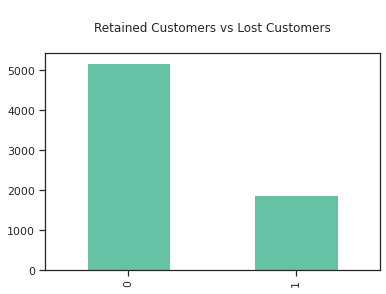

In [32]:
# check the distribution of our target
retained = len(df.query('target == 0'))
lost = len(df.query('target == 1'))
print('Number of Retained Customers:', retained,
     'Number of Lost Customers:', lost)
df.target.value_counts().plot(kind='bar') 
plt.title('\nRetained Customers vs Lost Customers\n');

__Observation__
- There is a sizable imbalance in our target data we will need to address for modeling.
- An imbalanced target will results in a skewed predictive model.

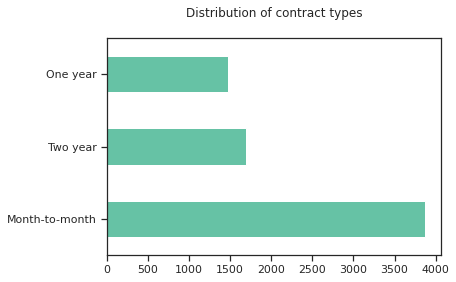

In [33]:
# check the distribution of our contract type
df.type.value_counts().plot(kind='barh') 
plt.title('Distribution of contract types\n');

Comparison of Contract Types by Retained and Lost Customers


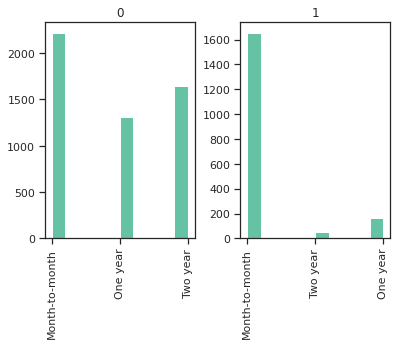

In [34]:
print('Comparison of Contract Types by Retained and Lost Customers')
df.hist(column='type', by='target');

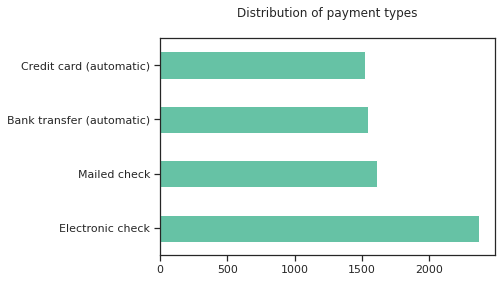

In [35]:
# check the distribution of our payment types
df.payment_method.value_counts().plot(kind='barh') 
plt.title('Distribution of payment types\n');

Comparison of Payment Types by Retained and Lost Customers


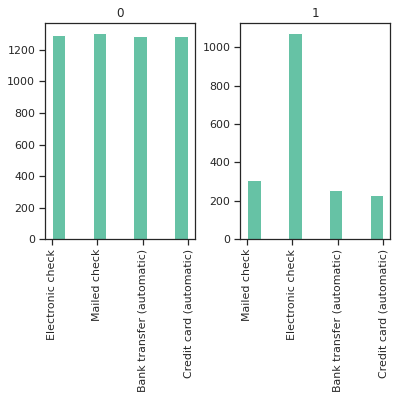

In [36]:
print('Comparison of Payment Types by Retained and Lost Customers')
df.hist(column='payment_method', by='target');

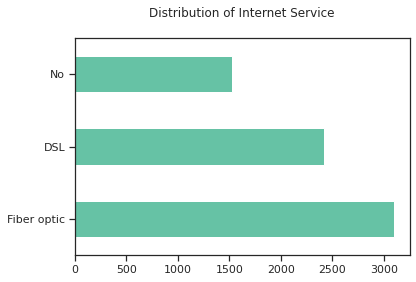

In [37]:
# check the distribution of our internet service
df.internet_service.value_counts().plot(kind='barh') 
plt.title('Distribution of Internet Service\n');

Comparison of Internet Service by Retained and Lost Customers


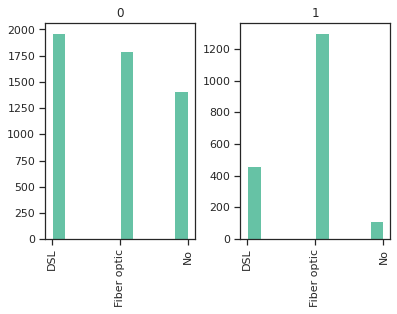

In [38]:
print('Comparison of Internet Service by Retained and Lost Customers')
df.hist(column='internet_service', by='target');

__Observation__
- Differences are noted between the retained and lost customers for the internet service type, payment type and type of contract. 

In [39]:
df.type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

In [40]:
# check to distribution of values in various columns
columns_distribution = [df.type, df.paperless_billing, df.payment_method, df.gender, df.senior_citizen,
          df.partner, df.dependents, df.internet_service, df.online_security, df.online_backup,
          df.device_protection, df.tech_support, df.streaming_t_v, df.streaming_movies, 
          df.multiple_lines, df.internet_customer, df.phone_customer]
# display distribution of column values
for x in columns_distribution:
    print(x.value_counts())

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64
Yes    4171
No     2872
Name: paperless_billing, dtype: int64
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64
Male      3555
Female    3488
Name: gender, dtype: int64
0    5901
1    1142
Name: senior_citizen, dtype: int64
No     3641
Yes    3402
Name: partner, dtype: int64
No     4933
Yes    2110
Name: dependents, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: internet_service, dtype: int64
No     5024
Yes    2019
Name: online_security, dtype: int64
No     4614
Yes    2429
Name: online_backup, dtype: int64
No     4621
Yes    2422
Name: device_protection, dtype: int64
No     4999
Yes    2044
Name: tech_support, dtype: int64
No     4336
Yes    2707
Name: streaming_t_v, dtype: int64
No     4311
Yes    2732
Name: streaming_movies, dtype: int64
N

__Observation__
- None of these columns have high dimensionality, so we can confidently use OHE.
- We will use drop_first=True to avoid skewing results due to overrepresentation of a value (i.e. yes implies no, so we don't need 2 columns to represent a Y/N column.

In [41]:
# columns for simple OHE where one value is dropped
columns_for_OHE = ['paperless_billing','gender','senior_citizen', 'partner', 'dependents', 
          'online_security', 'online_backup', 'device_protection', 'tech_support',
          'streaming_t_v', 'streaming_movies', 'multiple_lines', 'type','payment_method',
          'internet_service', 'internet_customer', 'phone_customer']
# use one hot encoding and drop the first value to avoid skewing due to double representation.
df = pd.get_dummies(df, drop_first=True, columns = columns_for_OHE)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   monthly_charges                         7043 non-null   float64
 1   total_charges                           7043 non-null   float64
 2   target                                  7043 non-null   int64  
 3   length_of_service                       7043 non-null   int64  
 4   paperless_billing_Yes                   7043 non-null   uint8  
 5   gender_Male                             7043 non-null   uint8  
 6   senior_citizen_1                        7043 non-null   uint8  
 7   partner_Yes                             7043 non-null   uint8  
 8   dependents_Yes                          7043 non-null   uint8  
 9   online_security_Yes                     7043 non-null   uint8  
 10  online_backup_Yes                       7043 non-null   uint

In [43]:
# once again change column names to all lower case
columns = []
for name in df.columns.values:
    name = re.sub('([A-Z])', r' \1', name).lower().replace(' ', '_')[0:]
    columns.append(name)
df.columns = columns
print(df.shape)
df.columns

(7043, 25)


Index(['monthly_charges', 'total_charges', 'target', 'length_of_service',
       'paperless_billing__yes', 'gender__male', 'senior_citizen_1',
       'partner__yes', 'dependents__yes', 'online_security__yes',
       'online_backup__yes', 'device_protection__yes', 'tech_support__yes',
       'streaming_t_v__yes', 'streaming_movies__yes', 'multiple_lines__yes',
       'type__one_year', 'type__two_year',
       'payment_method__credit_card_(automatic)',
       'payment_method__electronic_check', 'payment_method__mailed_check',
       'internet_service__fiber_optic', 'internet_service__no',
       'internet_customer__yes', 'phone_customer__yes'],
      dtype='object')

__Observations__
- With OHE and other manipulations we only increased the number of columns to 25 from the original 21.

In [44]:
# explore correlation table any strong correlations
df.corr()

,monthly_charges,total_charges,target,length_of_service,paperless_billing__yes,gender__male,senior_citizen_1,partner__yes,dependents__yes,online_security__yes,...,multiple_lines__yes,type__one_year,type__two_year,payment_method__credit_card_(automatic),payment_method__electronic_check,payment_method__mailed_check,internet_service__fiber_optic,internet_service__no,internet_customer__yes,phone_customer__yes
monthly_charges,1.000000,0.651182,0.193356,0.260860,0.352150,-0.014569,0.220173,0.096848,-0.113890,0.296594,...,0.490434,0.004904,-0.074681,0.030550,0.271625,-0.377437,0.787066,-0.763557,0.763557,0.247398
total_charges,0.651182,1.000000,-0.198347,0.829402,0.158562,-0.000087,0.102997,0.317532,0.062124,0.411679,...,0.468516,0.170807,0.354539,0.182913,-0.059268,-0.295740,0.361640,-0.375229,0.375229,0.113203
target,0.193356,-0.198347,1.000000,-0.311715,0.191825,-0.008612,0.150889,-0.150448,-0.164221,-0.171226,...,0.040102,-0.177820,-0.302253,-0.134302,0.301919,-0.091683,0.308020,-0.227890,0.227890,0.011942
length_of_service,0.260860,0.829402,-0.311715,1.000000,0.015029,0.004763,0.023454,0.378446,0.154648,0.324518,...,0.339155,0.197897,0.552891,0.230434,-0.198022,-0.241609,0.034422,-0.050250,0.050250,0.009635
paperless_billing__yes,0.352150,0.158562,0.191825,0.015029,1.000000,-0.011754,0.156530,-0.014877,-0.111377,-0.003636,...,0.163530,-0.051391,-0.147889,-0.013589,0.208865,-0.205398,0.326853,-0.321013,0.321013,0.016505
gender__male,-0.014569,-0.000087,-0.008612,0.004763,-0.011754,1.000000,-0.001874,-0.001808,0.010517,-0.017021,...,-0.008414,0.008026,-0.003695,0.001215,0.000752,0.013744,-0.011286,0.006026,-0.006026,-0.006488
senior_citizen_1,0.220173,0.102997,0.150889,0.023454,0.156530,-0.001874,1.000000,0.016479,-0.211185,-0.038653,...,0.142948,-0.046262,-0.117000,-0.024135,0.171718,-0.153477,0.255338,-0.182742,0.182742,0.008576
partner__yes,0.096848,0.317532,-0.150448,0.378446,-0.014877,-0.001808,0.016479,1.000000,0.452676,0.143106,...,0.142057,0.082783,0.248091,0.082029,-0.083852,-0.095125,0.000304,0.000615,-0.000615,0.017706
dependents__yes,-0.113890,0.062124,-0.164221,0.154648,-0.111377,0.010517,-0.211185,0.452676,1.000000,0.080972,...,-0.024526,0.068368,0.204613,0.060267,-0.150642,0.059071,-0.165818,0.139812,-0.139812,-0.001762
online_security__yes,0.296594,0.411679,-0.171226,0.324518,-0.003636,-0.017021,-0.038653,0.143106,0.080972,1.000000,...,0.098108,0.100162,0.191773,0.115721,-0.112338,-0.080798,-0.030696,-0.333403,0.333403,-0.092893


__Observations__
- It appears there are no medium or strong *single* feature correlations with the target feature.
- There may be some combined correlations which the models should help tease out.
- While some features may not be useful, we will keep all these features and prune back to the obvious if the model becomes overfitted or doesn't reach the ROC scores.

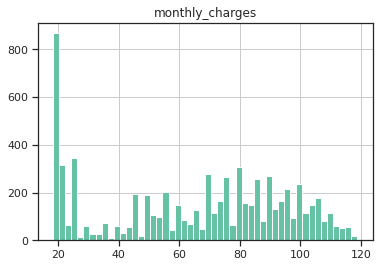

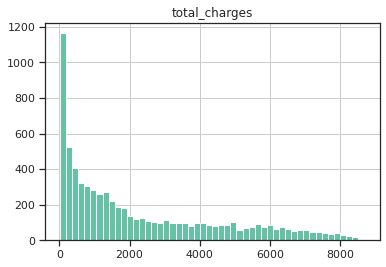

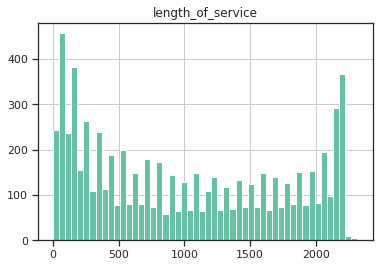

In [45]:
# explore patterns for some features
for feature in ['monthly_charges','total_charges','length_of_service']:
    df.hist(feature, bins=50);

__Observations__
- There appears to be a cluster of customers who enjoy a modest plan around 20 dollars. The maximum appears to be less than 120 dollars. There is a wide range of price points, perhaps indicating a complex pricing a la carte pricing scheme.
- The total charges skew towards a lower amount which makes sense because the average user doesn't pay that much a month. It would take some time to reach 8,000 dollars.
- While some customers have been with the company for a long time (over 2000 days), there is actually a pretty wide variation of lengths of service.

<a class="anchor" id="monthly_charges"></a> 

**Monthly Charges** 

In [46]:
# create two separate df for retained and lost customers
df_retained = df.query('target == 0')
df_lost = df.query('target == 1')

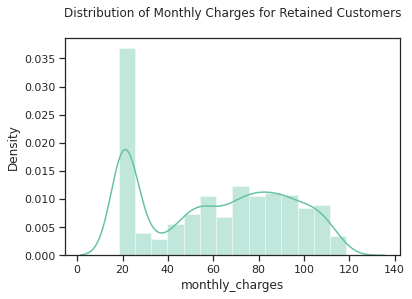

In [47]:
# display a histogram of retained customer monthly_charges
# referenced seaborn tutorial at https://seaborn.pydata.org/tutorial/distributions.html
sns.distplot(df_retained.monthly_charges, kde=True).set(
    title='Distribution of Monthly Charges for Retained Customers\n');

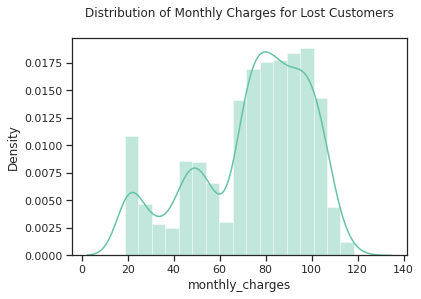

In [48]:
# display a histogram of lost customer monthly_charges
# Referenced seaborn tutorial at https://seaborn.pydata.org/tutorial/distributions.html
sns.distplot(df_lost.monthly_charges, kde=True).set(title='Distribution of Monthly Charges for Lost Customers\n');

__Observations__
- There is a notable difference in the distribution of monthly charges between the retained customers and the lost customers. 
- A majority of the retained customers are in the lower monthly payments (30 dollars or less), with a healthy spread of customers between 40 and 110 dollars a month.
- The lost customers were, on average, paying quite a bit more. The bulk of their monthly bill occurred in the 70 to 110 dollar range. Were they being overcharged and that is why they left? Or were they bundling many services together and found a cheaper provider who offered a better deal?

**Monthly Charges Statistics** 

In [49]:
# calculate statistics for retained customers
df_retained_avg = round(df_retained.monthly_charges.mean())
df_retained_min = round(df_retained.monthly_charges.min())
df_retained_max = round(df_retained.monthly_charges.max())
df_retained_med = round(df_retained.monthly_charges.median())
df_retained_25 = np.percentile(df_retained.monthly_charges, 25).round(2)
df_retained_75 = np.percentile(df_retained.monthly_charges, 75).round(2)

# calculate statistics for lost customers
df_lost_avg = round(df_lost.monthly_charges.mean())
df_lost_min = round(df_lost.monthly_charges.min())
df_lost_max = round(df_lost.monthly_charges.max())
df_lost_med = round(df_lost.monthly_charges.median())
df_lost_25 = np.percentile(df_lost.monthly_charges, 25).round(2)
df_lost_75 = np.percentile(df_lost.monthly_charges, 75).round(2)

In [50]:
# table for displaying statistics
def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4></td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

print('Table of Statistics for Retained and Lost Customers')
data = [['Customer Type', 'Mean', 'Minimum', 'Maximum', 'Median', '25%', '75%'],
        ['Retained',df_retained_avg, df_retained_min, df_retained_max, df_retained_med,
         df_retained_25, df_retained_75],
        ['Lost',df_lost_avg,df_lost_min,df_lost_max,df_lost_med,df_lost_25, df_lost_75]]
display_table(data)

Table of Statistics for Retained and Lost Customers


Customer Type,Mean,Minimum,Maximum,Median,25%,75%
Retained,61,18,119,64,25.1,88.4
Lost,74,19,118,80,56.15,94.2


__Observations__
- The lost customer were actually paying twice as much at the 25% percentile. For whatever reason, their monthly charges were quite a bit larger.
- However, it is interesting that the minimum and maximums are about the same. 
- The mean, median, and 75% percentile all demonstrate a higher monthly bill for the customers lost.


<a class="anchor" id="telephone_internet"></a>


**Telephone and Internet Users** 

In [51]:
df.head()

,monthly_charges,total_charges,target,length_of_service,paperless_billing__yes,gender__male,senior_citizen_1,partner__yes,dependents__yes,online_security__yes,...,multiple_lines__yes,type__one_year,type__two_year,payment_method__credit_card_(automatic),payment_method__electronic_check,payment_method__mailed_check,internet_service__fiber_optic,internet_service__no,internet_customer__yes,phone_customer__yes
0,29.85,29.85,0,31,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,56.95,1889.50,0,1036,0,1,0,0,0,1,...,0,1,0,0,0,1,0,0,1,1
2,53.85,108.15,1,123,1,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,1
3,42.30,1840.75,0,1371,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
4,70.70,151.65,1,153,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1


In [52]:
# create separate dfs for verified internet and phone customers and internet and phone
df_internet = df.query('internet_customer__yes == 1')
df_phone = df.query('phone_customer__yes == 1')
df_both = df.query('internet_customer__yes == 1 and phone_customer__yes == 1')
print('Number of internet customers:', df_internet.shape)
print('Number of phone customers:',df_phone.shape)
print('Number of customers with both:',df_both.shape)

Number of internet customers: (5517, 25)
Number of phone customers: (6361, 25)
Number of customers with both: (4835, 25)


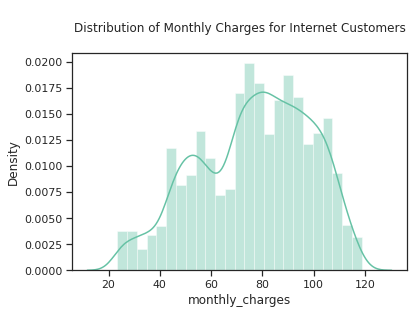

In [53]:
# display a histogram for internet customers
# Referenced seaborn tutorial at https://seaborn.pydata.org/tutorial/distributions.html
sns.distplot(df_internet.monthly_charges, kde=True).set(
    title='\nDistribution of Monthly Charges for Internet Customers\n');

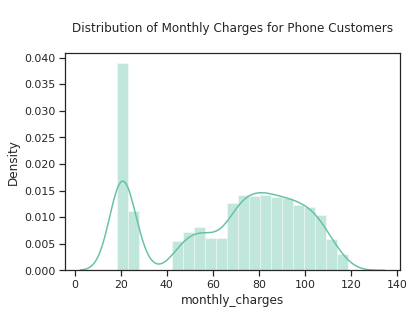

In [54]:
# display a histogram for phone customers
# Referenced seaborn tutorial at https://seaborn.pydata.org/tutorial/distributions.html
sns.distplot(df_phone.monthly_charges, kde=True).set(
    title='\nDistribution of Monthly Charges for Phone Customers\n');

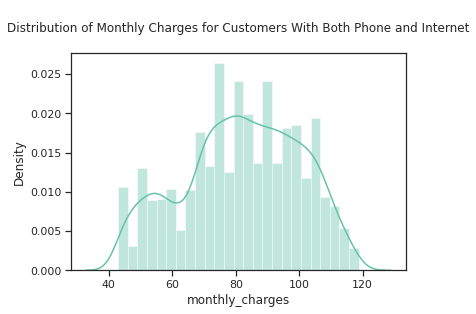

In [55]:
# display a histogram for phone customers
# Referenced seaborn tutorial at https://seaborn.pydata.org/tutorial/distributions.html
sns.distplot(df_both.monthly_charges, kde=True).set(
    title='\nDistribution of Monthly Charges for Customers With Both Phone and Internet\n');

__Observations__
- There is an uneven number of Internet customers (5517) and phone customers (6361).
- Many customers (4835) have both services.
- The distribution of their monthly charges are similar except for the strong spike around 20 dollars for the phone customers.
- While it is not a big surprise, those customers with both services spend more per month than those without either.


<a class="anchor" id="modeling_plan"></a>

# Modeling plan

"A rough plan for solving the task, specifying 3-5 basic steps and explaining each step in one or two sentences"

1. We will split the data into train, valid, and test sets.
2. We will create a function to calculate and print the scores for the models to increase efficiency.
3. We will run various models, including Linear Regression, Random Forest, LightGBM and the CatBoost models. We will tune hyperparameters.
4. We will use various methods such as class_weight='balanced', downsampling, and upsampling to adjust for the imbalanced target data.
5. We will use a dummy classifier to compare our final results, i.e. the sanity check.

<a class="anchor" id="function_for_scores"></a>

## Create a function to calculate and print the scores for the models

In [56]:
# reused code from sentiment analysis sprint

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    # return values
    return 

<a class="anchor" id="split_data"></a>

## Split the data into train, valid, and test sets

In [57]:
# create feature and target variables 
target = df['target']
features = df.drop(['target'], axis=1)

In [58]:
# divide data with OHE into 3 groups using 3:1:1 (60%, 20%, 20%) ratio
X_train, X_valid, y_train, y_valid = train_test_split(
    features, target, test_size=0.4, random_state = 12345)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid, y_valid, test_size=0.5, shuffle = False, random_state=12345)
print('Train target and features and percentage\n', y_train.shape, X_train.shape,
      'pct', (len(y_train)/len(df)))
print('Valid target and features and percentage\n', y_valid.shape, X_valid.shape,
      'pct', (len(y_valid)/len(df)))
print('Test target and features and percentage\n', y_test.shape, X_test.shape,
      'pct', (len(y_test)/len(df)))

Train target and features and percentage
 (4225,) (4225, 24) pct 0.5998864120403238
Valid target and features and percentage
 (1409,) (1409, 24) pct 0.20005679397983814
Test target and features and percentage
 (1409,) (1409, 24) pct 0.20005679397983814


<a class="anchor" id="explore_balance"></a>

## Explore the balance of classes in the target

In [59]:
print('Balance for target (either 0 or 1)')
train_ohe_frequency = (y_train.value_counts(normalize=True) * 100).round(2)
valid_ohe_frequency = (y_valid.value_counts(normalize=True) * 100).round(2)
test_ohe_frequency = (y_test.value_counts(normalize=True) * 100).round(2)
print('% ohe Training Target balance of retained to lost customers \n', train_ohe_frequency)
print('\n% ohe Validation Target balance of retained to lost customers  \n', valid_ohe_frequency)
print('\n% ohe Test Target balance of retained to lost customers  \n', test_ohe_frequency)

# https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html 

Balance for target (either 0 or 1)
% ohe Training Target balance of retained to lost customers 
 0    73.94
1    26.06
Name: target, dtype: float64

% ohe Validation Target balance of retained to lost customers  
 0    73.1
1    26.9
Name: target, dtype: float64

% ohe Test Target balance of retained to lost customers  
 0    72.39
1    27.61
Name: target, dtype: float64


__Observation__
- Our sample is imbalanced, about 73% of our target column indicates retained, so if we use this unbalanced data for our models our accuracy will be skewed towards retained and won't accurately predict the customers likely to leave. 
- We will need to take steps to address the unbalanced distribution model that will predict 0 in every instance because of the unbalanced data.

<a class="anchor" id="model_building"></a>

## Model Building

__Dummy Classifier__
- Baseline 'Sanity Check' Model.
- No adjustments to balance (the target value remains imbalanced).
- Selected the constant strategy.

In [60]:
model_0 = DummyClassifier(strategy='constant', constant=1)
model_0.fit(X_train, y_train)

DummyClassifier(constant=1, strategy='constant')

          train  test
Accuracy   0.26  0.28
F1         0.41  0.43
APS        0.26  0.28
ROC AUC    0.50  0.50


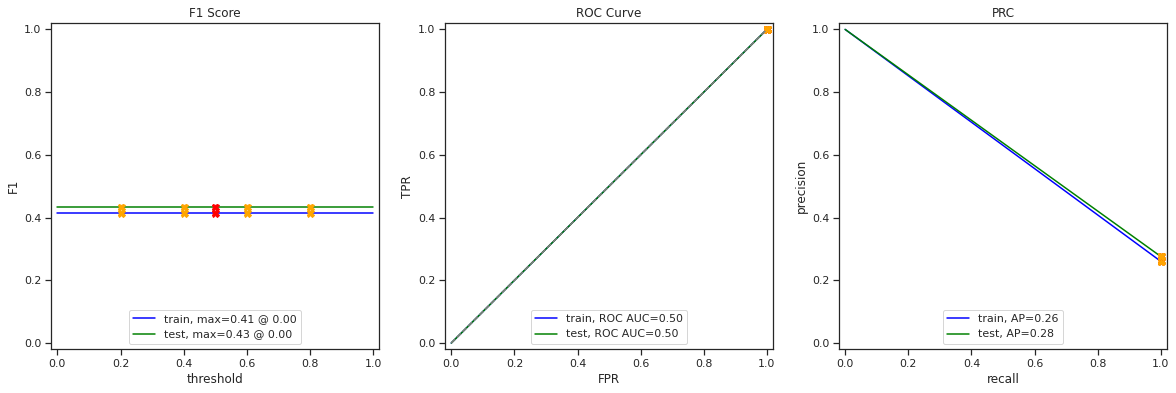

In [61]:
# evaluate constant model
model_0_eval = evaluate_model(model_0, X_train, y_train, X_test, y_test)

__Observation__
- It means that to pass the sanity check our model must do score better than .28 on the accuracy metric when our chosen model is run with the test data.

__Logistic Regression__
- We will use class_weight='balanced' to adjust for the imbalance of the target class. 

In [62]:
# create logistic regression model using class_weight='balanced'
lr = LogisticRegression(random_state=12345, class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=12345)

In [63]:
lr.predict(X_valid)

array([0, 1, 1, ..., 0, 0, 0])

          train  test
Accuracy   0.75  0.75
F1         0.62  0.62
APS        0.65  0.65
ROC AUC    0.84  0.84


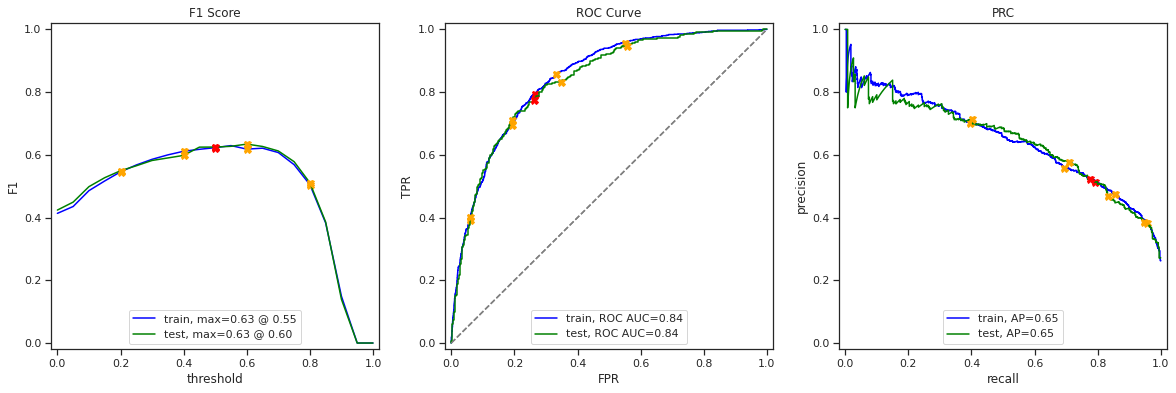

In [64]:
lr_eval = evaluate_model(lr, X_train, y_train, X_valid, y_valid)

__Observations__
- Already the accuracy score is far better (.75 on the validation data).

__Decision Tree__
- Once again we will use the class_weight='balanced.'

In [65]:
# build decision tree model
dt = DecisionTreeClassifier(random_state=12345)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=12345)

          train  test
Accuracy    1.0  0.83
F1          1.0  0.68
APS         1.0  0.55
ROC AUC     1.0  0.78


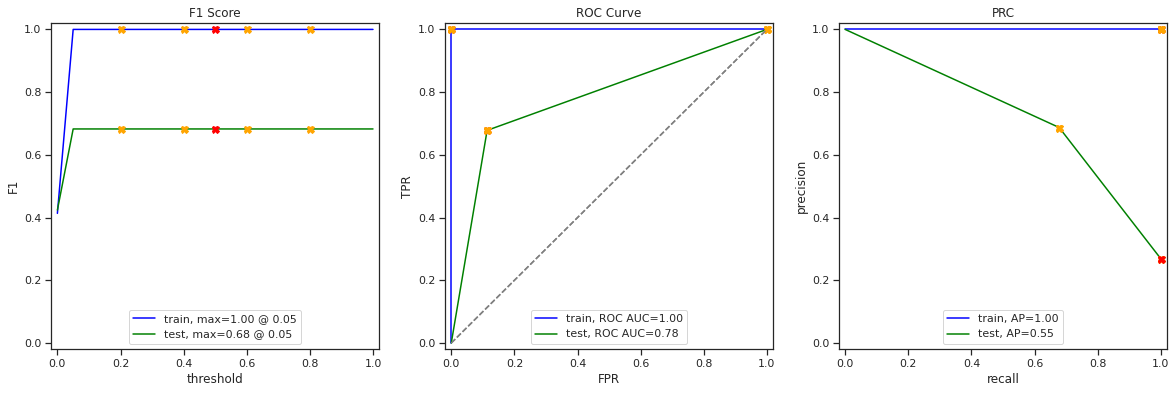

In [66]:
dt_eval = evaluate_model(dt, X_train, y_train, X_valid, y_valid)

__Observations__
- This model is overfitting to the training data.
- Tuning the hyperparameters could help.
- The accuracy is higher than LR at 0.83 on the valid data.

__Random Forest__
- Once again we will use the class_weight='balanced'

          train  test
Accuracy    1.0  0.83
F1          1.0  0.63
APS         1.0  0.76
ROC AUC     1.0  0.87


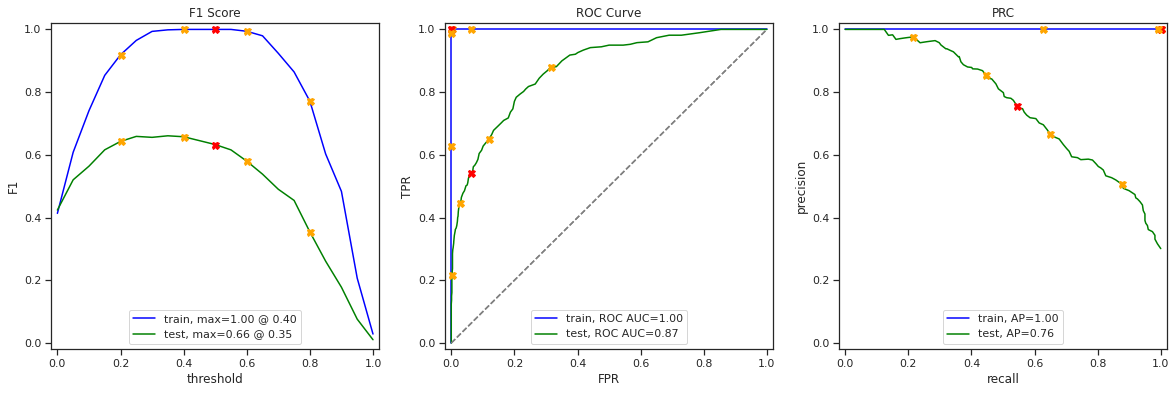

In [67]:
rf = RandomForestClassifier(random_state=12345, class_weight='balanced')
rf.fit(X_train, y_train)
rt_eval = evaluate_model(rf, X_train, y_train, X_valid, y_valid)

__Observations__
- This model is overfitting to the training data.
- Tuning the hyperparameters could help.
- The accuracy is higher than LR at 0.83 on the valid data.

__CatBoost__

          train  test
Accuracy   0.94  0.89
F1         0.87  0.76
APS        0.96  0.88
ROC AUC    0.98  0.93


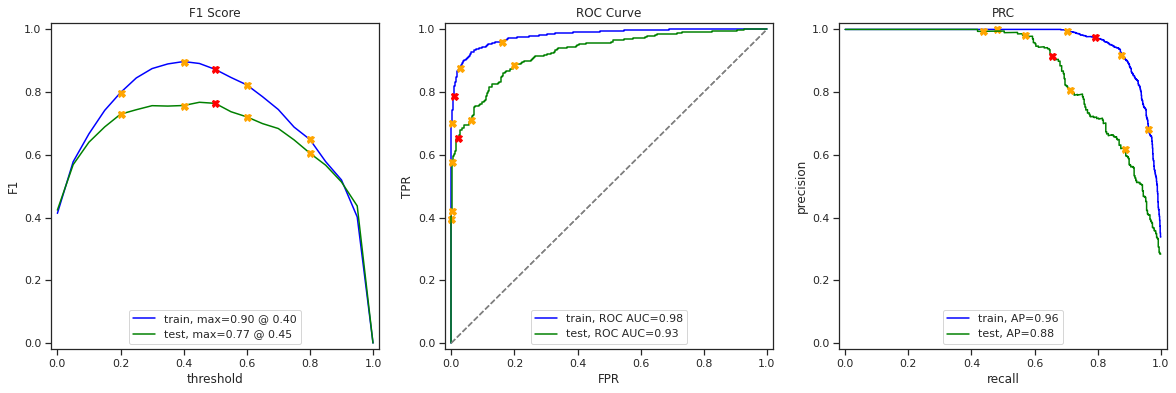

In [68]:
cb = CatBoostClassifier(random_state=12345, verbose=0)
cb.fit(X_train, y_train)

cb_eval = evaluate_model(cb, X_train, y_train, X_valid, y_valid)

__Observations__
- Accuracy on the validation data is impressive at 0.89.
- The ROC is also high.
- There is some overfitting to the training data.

__LGBM Classifier__


          train  test
Accuracy   0.97  0.89
F1         0.93  0.76
APS        0.99  0.87
ROC AUC    1.00  0.92


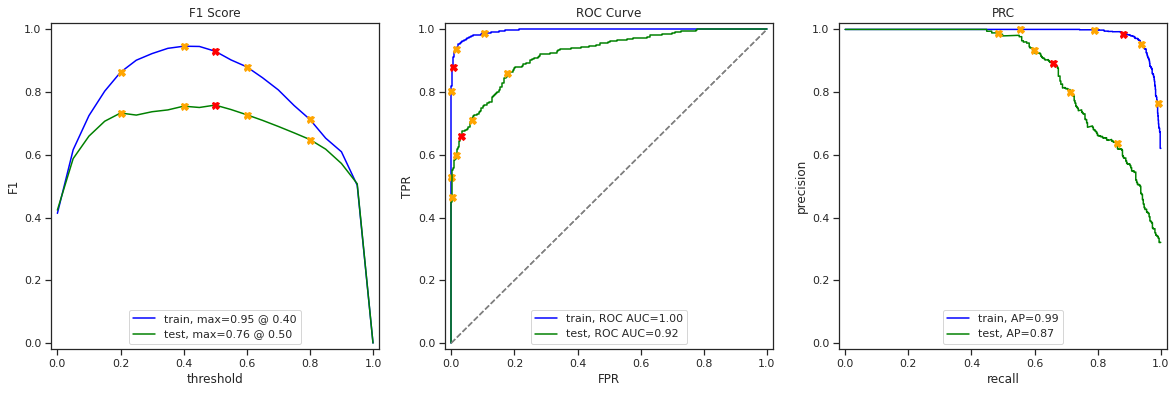

In [69]:
lgb = LGBMClassifier(random_state=12345)
lgb.fit(X_train, y_train)

lgb_eval = evaluate_model(lgb, X_train, y_train, X_valid, y_valid)

__Observations__
- The accuracy is strong at 0.89.
- However, there is some overfitting to the train data.

__XGB Classifier__

[03:53:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          train  test
Accuracy   1.00  0.88
F1         0.99  0.76
APS        1.00  0.87
ROC AUC    1.00  0.92


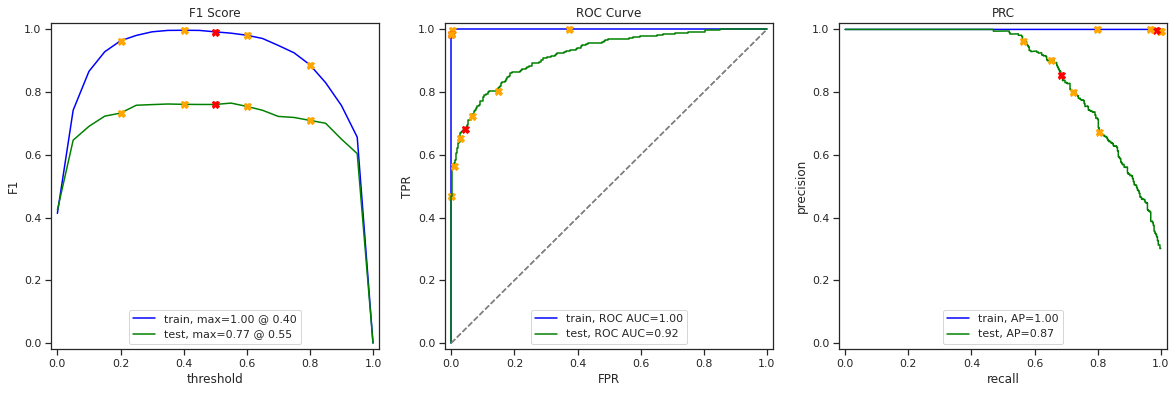

In [70]:
XGBClassifier
xgb = XGBClassifier(random_state=12345)
xgb.fit(X_train, y_train)

xgb_eval = evaluate_model(xgb, X_train, y_train, X_valid, y_valid)

__Observations__
- The accuracy is strong at 0.88 on the validation set.
- However, there is some overfitting to the train data.

| Model                     | ROC train | ROC valid | Accuracy train | Accuracy valid |
|--------------------------|-----------------|--------------------|-------------|-------------|
| Dummy Classifier               | 0.50          | 0.50              | 0.26        | 0.28 |
| Logistic Regression                  | 0.84           | 0.84              | 0.75       | 0.75 |
| Decision Tree                | 1.0           | 0.78                | 1.0         | 0.83|
| Random Forest                | 1.0           | 0.87              | 1.0       | 0.83 |
| CatBoost              | 0.98           | 0.93               | 0.94       | 0.89 |
| LGBM                 | 0.97           | 0.89              | 1.00       | 0.92 |
| XGB            | 1.0           | 0.92              | 1.0       | 0.88 |


__Observations__
- From the results CatBoost and LGBM are both models worth runing with the test data.
- LGBM has the highest accuracy, CatBoost the second highest.
- CatBoost has the highest ROC, XGB has the second highest ROC (but it appears to suffer more from overfitting).

__Test the CatBoost with the test data__

          train  test
Accuracy   0.94  0.88
F1         0.87  0.74
APS        0.96  0.88
ROC AUC    0.98  0.93


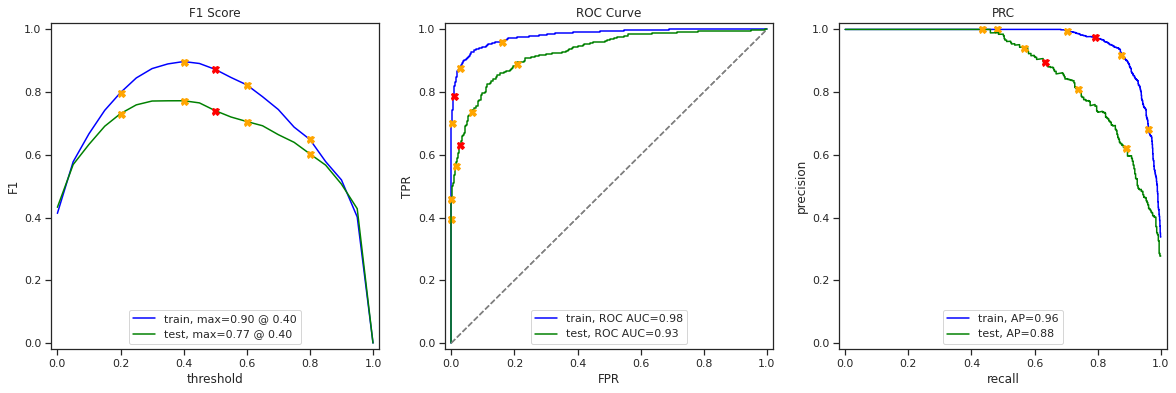

In [71]:
final_result = evaluate_model(cb, X_train, y_train, X_test, y_test)

<a class="anchor" id="conclusions"></a>

## Overview and conclusions

Steps:
1. [Load and inspect the data](#load_inspect): load, inspect, and create a basic plan.
2. [Data preprocessing](#data_preprocessing): merge files, change datatypes, and change column names.
3. [Exploratory data analysis](#exploratory_data_analysis): check for distribution of values, correlations, and patterns. Also, create and/or drop columns as needed and use OHE for categorical columns.
4. [Modeling plan](#modeling_plan): Create a basic plan for model building and assesment.
5. [Function for scores](#function_for_scores): Use a function to calculate and print the scores for the models.
6. [Split data](#split_data): Split the data into train, validation, and test sets.
7. [Explore balance](#explore_balance): If the data is imbalanced, consider using methods such as class_weight='balanced', downsampling, and upsampling to adjust for the imbalance target data.
8. [Build models](#model_building): Set up various models including Linear Regression, Random Forest, LightGBM and the CatBoost models. Consider tuning hyperparameters if AUC-ROC metrics are not met.
9. [Conclusions](#conclusions)

__What is your final model and what quality score does it have?__

- We selected the CatBoost model for our final model since it scored the highest ROC score on the validation data.
- The CatBoost model performs very well on the test data, demonstrating a high accuracy (0.88) and high ROC score (0.93) (well above the 0.88 threshold given in the project description).
- The CatBoost model performed well above the 0.5 ROC metric for the Dummy Classifier (sanity model).


[Return to Top of Document](#top_of_document)

## Additional discussion of project

__What steps of the plan were performed and what steps were skipped__
- Data was preprocessed (files merged, column names changed to lower case for uniformity, missing values found/filled in, checked for duplicate rows, datatypes changed as appropriate).
- During exploratory data analysis, we checked for imbalance with the target feature, comparison of some features with the target feature, checked columns for high dimensionality prior to applying OHE, created some graphs looking for relationships, checked a correlation table to see if any specific features had a strong correlation with the target
- We borrowed the function to calculate ROC/Accuracy and display graphs from a previous project.
- We split the data into 3:1:1 train, valid, test groups.
- We began building models and included steps to adjust for the imbalance of the target class.
- We built the Dummy Classifier to serve as a sanity check (are the results we produce better than chance?)
- We created Logistic Regression model and used class_weight='balanced' to adjust for the imbalance of the target class. 
- Note we did not use upsampling or downsampling with LR. While they may have improved the LR performance, we anticipated the LGB or CatBoost would offer superior results and decided to go back and try upsampling downsampling only if needed to reach our metric.
- We created Decision Tree and Random Forest models and used class_weight='balanced' to adjust for the imbalance of the target class. 
- Note we did not tune the hyperparmeters for these models. While they were overfitted and tuning would have helped, we decided to try LGB or CatBoost first before we attempted to tune the Decision Tree or Random Forest models.
- We created CatBoost, LGBM, XGB models and left the defaults since boosting models generally do well with imbalanced data.
- Note we did not adjust the scale_pos_weight for these models, but would have if we had not reached the target metric.

__What difficulties did you encounter and how did you manage to solve them__
- During preprocessing total monthly charge did not have any missing values, but after a little investigation we discovered brand new customers (those who joined the day of data extraction) had a blank field for total monthly charges. We filled it in with monthly changes since this was their first month.
- We debated about eliminating more columns since too many columns can sometimes cause poorer results, but since we found good results with all columns (besides dropped customer id, begin date, end date), we didn't need to. We knew we could always go back and prune our data.

__What were some of the key steps to solving the task__ 
- Solid preprocessing and OHE of the data made it available for the models.
- Separating the data into train, valid and, test allowed proper model building and testing.
- Using a useful function to calculate the ROC and accuracy.
- Fitting different models on the training data and then verifying the models with the validation data.
- Selecting the most promising model to run with the test data.
- Knowing what other steps (upsampling or downsampling with LR, hyperparameter tuning, scale_pos_weight adjustments) could help reach the metric if needed.

__References__

[For table](https://stackoverflow.com/questions/35160256/how-do-i-output-lists-as-a-table-in-jupyter-notebook)

[XGBoost & LightGBM & Catboost - Imbalanced Data](https://www.kaggle.com/code/kaanboke/xgboost-lightgbm-catboost-imbalanced-data/notebook)

[Tuning Decision Trees](https://www.kaggle.com/code/gauravduttakiit/hyperparameter-tuning-in-decision-trees/notebook)




